IMDb dataset already downloaded and extracted.
Train size: 7000, Validation size: 1500, Test size: 1500

[ K-Means Clustering ]
Validation Accuracy: 0.5247

[ Linear Perceptron ]
Validation Metrics:
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       744
           1       0.84      0.79      0.81       756

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500


[ Multi-Layer Perceptron (MLP) ]
Validation Metrics:
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       744
           1       0.87      0.87      0.87       756

    accuracy                           0.87      1500
   macro avg       0.87      0.87      0.87      1500
weighted avg       0.87      0.87      0.87      1500



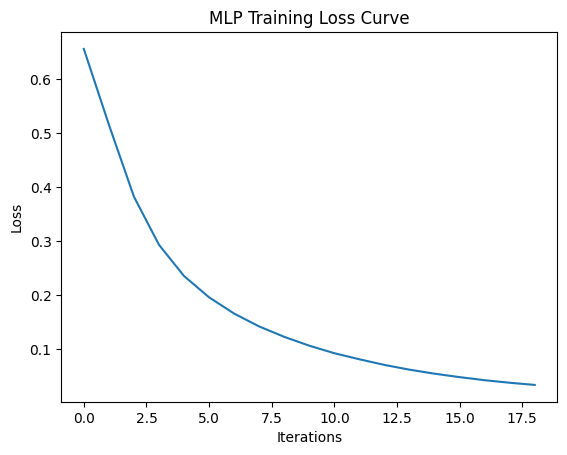


[ Final Test Results ]
K-Means Test Accuracy: 0.5127

Perceptron Test Metrics:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82       731
           1       0.86      0.78      0.82       769

    accuracy                           0.82      1500
   macro avg       0.82      0.82      0.82      1500
weighted avg       0.82      0.82      0.82      1500


MLP Test Metrics:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       731
           1       0.87      0.82      0.85       769

    accuracy                           0.85      1500
   macro avg       0.85      0.85      0.85      1500
weighted avg       0.85      0.85      0.85      1500



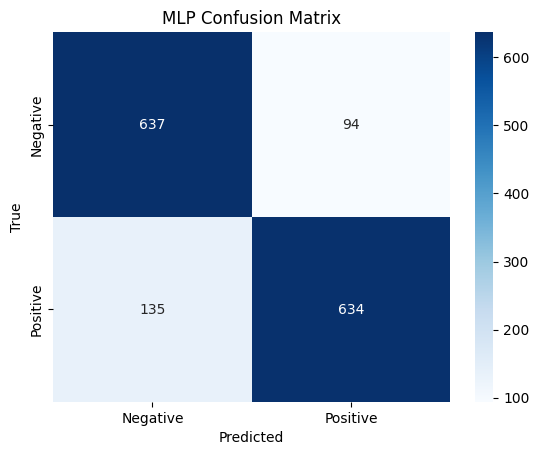

In [2]:
# Sentiment Analysis on IMDb Movie Reviews
# Algorithms: K-Means, Linear Perceptron, Multi-Layer Perceptron (MLP)
# Authors: Roman Mordovtsev, Mehmet Fatih Karaosman

# --- Step 1: Download and Extract IMDb Dataset ---
import os

dataset_url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset_tar = "aclImdb_v1.tar.gz"

if not os.path.exists('aclImdb'):
    print("Downloading IMDb dataset...")
    !wget $dataset_url
    print("Extracting dataset...")
    !tar -xzf $dataset_tar
else:
    print("IMDb dataset already downloaded and extracted.")

# --- Step 2: Import Libraries ---
import numpy as np
import pandas as pd
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

# --- Step 3: Load Data ---
dataset = load_files('./aclImdb/train', categories=['pos', 'neg'], shuffle=True)
X_raw, y = dataset.data, dataset.target

# Subsample to 10,000 reviews (5k positive, 5k negative)
X_raw = X_raw[:10000]
y = y[:10000]

# --- Step 4: Text Vectorization with TF-IDF ---
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform([x.decode('utf-8', errors='ignore') for x in X_raw])

# --- Step 5: Split Dataset into Train/Validation/Test (70%/15%/15%) ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"Train size: {X_train.shape[0]}, Validation size: {X_val.shape[0]}, Test size: {X_test.shape[0]}")

# --- Part 1: K-Means Clustering ---
print("\n[ K-Means Clustering ]")
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans.fit(X_train)

# Map cluster IDs to sentiment labels
cluster_to_label = {}
for cluster_id in [0, 1]:
    mask = (kmeans.labels_ == cluster_id)
    majority_label = mode(np.array(y_train)[mask], keepdims=True).mode[0]
    cluster_to_label[cluster_id] = majority_label

# Evaluate on validation set
predicted_clusters = kmeans.predict(X_val)
predicted_labels = np.vectorize(cluster_to_label.get)(predicted_clusters)
kmeans_accuracy = accuracy_score(y_val, predicted_labels)
print(f"Validation Accuracy: {kmeans_accuracy:.4f}")

# --- Part 2: Linear Perceptron Classifier ---
print("\n[ Linear Perceptron ]")
perceptron = Perceptron(max_iter=1000, random_state=42)
perceptron.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_perceptron = perceptron.predict(X_val)
print("Validation Metrics:")
print(classification_report(y_val, y_val_pred_perceptron))

# --- Part 3: Multi-Layer Perceptron (MLP) Classifier ---
print("\n[ Multi-Layer Perceptron (MLP) ]")
mlp = MLPClassifier(
    hidden_layer_sizes=(100,),
    max_iter=200,
    solver='adam',
    early_stopping=True,
    validation_fraction=0.1,
    random_state=42
)
mlp.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred_mlp = mlp.predict(X_val)
print("Validation Metrics:")
print(classification_report(y_val, y_val_pred_mlp))

# Plot training loss curve for MLP
plt.plot(mlp.loss_curve_)
plt.title("MLP Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

# --- Final Evaluation on Test Set ---
print("\n[ Final Test Results ]")

# K-Means
test_pred_clusters = kmeans.predict(X_test)
test_pred_labels = np.vectorize(cluster_to_label.get)(test_pred_clusters)
print(f"K-Means Test Accuracy: {accuracy_score(y_test, test_pred_labels):.4f}")

# Perceptron
y_test_pred_perceptron = perceptron.predict(X_test)
print("\nPerceptron Test Metrics:")
print(classification_report(y_test, y_test_pred_perceptron))

# MLP
y_test_pred_mlp = mlp.predict(X_test)
print("\nMLP Test Metrics:")
print(classification_report(y_test, y_test_pred_mlp))

# Confusion Matrix for MLP
cm = confusion_matrix(y_test, y_test_pred_mlp)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("MLP Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()